In [1]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [2]:
import numpy as np
import dlib
import cv2
from os import listdir
from os.path import isfile, isdir, join
from face_helper import rect_to_bb, shape_to_np, FACIAL_LANDMARKS_IDXS
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    '/Users/kirillovchinnikov/.virtualenvs/chat_env/lib/python3.6/site-packages/face_recognition_models/models/shape_predictor_68_face_landmarks.dat')

EMO_DICT = {
    -1: 'Not file',
    0: 'Neutral',
    1: 'Anger',
    2: 'Contempt',
    3: 'Disgust',
    4: 'Fear',
    5: 'Happy',
    6: 'Sad',
    7: 'Surprise'
}


def shape_rotate(shape, angle, dtype="float"):
    coords = np.zeros((len(shape), 2), dtype=dtype)
    angle = angle * np.pi / 180.0
    for i in range(0, len(shape)):
        coords[i][0] = shape[i][0] * np.cos(angle) + shape[i][1] * np.sin(angle)
        coords[i][1] = -shape[i][0] * np.sin(angle) + shape[i][1] * np.cos(angle)

        # print(coords[i][0] - shape[i][0])
        # print(coords[i][1] - shape[i][1])

    return coords


def shape_normalize(shape):
    coords = np.zeros((len(shape), 2), dtype='float')

    maxX = np.amax(shape[:, 0])
    minX = np.amin(shape[:, 0])
    maxY = np.amax(shape[:, 1])
    minY = np.amin(shape[:, 1])

    scaleX = 1 / (maxX - minX)
    scaleY = 1 / (maxY - minY)
    
    scaleMin = scaleY
    
    if scaleX < scaleY:
        scaleMin = scaleX
    

    for i in range(0, len(shape)):
        coords[i][0] = (shape[i][0] - minX) * scaleMin
        coords[i][1] = (shape[i][1] - minY) * scaleMin

    return coords

In [4]:
kanade_set = '/Users/kirillovchinnikov/Downloads/binary/cohn-kanade-images'

kanade_emotions_set = '/Users/kirillovchinnikov/Downloads/binary/Emotion'

dir_list = [f for f in listdir(kanade_set) if isdir(join(kanade_set, f))]

data_for_X = []

data_for_y = []

for dir_kanade in log_progress(dir_list):
    subdir_folder = join(kanade_set, dir_kanade)
    subdir_list = [f for f in listdir(subdir_folder) if isdir(join(subdir_folder, f))]
    for image_subdir in subdir_list:
        image_folder = join(subdir_folder, image_subdir)
        target_emotion_folder = join(join(kanade_emotions_set, dir_kanade), image_subdir)
        target_emotion = -1
        if isdir(target_emotion_folder):
            target_emotion_files = [f for f in listdir(target_emotion_folder)
                                    if isfile(join(target_emotion_folder, f))
                                    and f.split('.')[-1] == 'txt']
            if len(target_emotion_files) > 0:
                target_emotion_file = join(target_emotion_folder, target_emotion_files[0])
                with open(target_emotion_file, 'r') as emotion_file:
                    target_emotion = int(float(emotion_file.read()))
        image_list = [f for f in listdir(image_folder) if isfile(join(image_folder, f)) and f.split('.')[-1] == 'png']
        image_list.sort()
        images_len = len(image_list)
        for i, image_filename in enumerate(image_list):
            data_emotions = 2
            if target_emotion == 1:
                data_emotions = 6
            elif target_emotion == 3:
                data_emotions = 5
            elif target_emotion == 5:
                data_emotions = 4
            elif target_emotion == 7:
                data_emotions = 3
            image_emotion = -1
            if i == 0 and i <= (images_len / 2) and data_emotions > 2:
                image_emotion = 0
            elif i >= (images_len - data_emotions) and i > (images_len / 2) and data_emotions > 2:
                image_emotion = target_emotion
            else:
                continue


            image_file = join(image_folder, image_filename)
            image = cv2.imread(image_file, 1)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            rects = detector(gray, 1)

            if len(rects) > 0:
                rect = rects[0]
            else:
                continue

            shape = predictor(gray, rect)
            shape = shape_to_np(shape)

            (lStart, lEnd) = FACIAL_LANDMARKS_IDXS["left_eye"]
            (rStart, rEnd) = FACIAL_LANDMARKS_IDXS["right_eye"]
            leftEyePts = shape[lStart:lEnd]
            rightEyePts = shape[rStart:rEnd]

            leftEyeCenter = leftEyePts.mean(axis=0)
            rightEyeCenter = rightEyePts.mean(axis=0)

            dY = rightEyeCenter[1] - leftEyeCenter[1]
            dX = rightEyeCenter[0] - leftEyeCenter[0]
            angle = np.degrees(np.arctan2(dY, dX)) - 180.0

            for (x, y) in shape:
                cv2.circle(image, (x, y), 1, (0, 0, 255), -1)

            shape_r = shape_rotate(shape, angle)
            shape_n = shape_normalize(shape_r)

            data_for_X.append(shape_n)
            data_for_y.append(image_emotion)

In [5]:
x_array = np.array(data_for_X, dtype='float')
y_array = np.array(data_for_y, dtype='int')

In [6]:
np.save('x_array.txt', x_array)
np.save('y_array.txt', y_array)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [8]:
x_stack = np.array([np.hstack(f) for f in x_array])
x_array.shape

(1319, 68, 2)

In [9]:
len(y_array[y_array == 7])

247

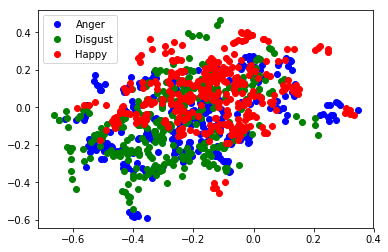

In [55]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(x_stack)
X_pca = pca.transform(x_stack)

# И нарисуем получившиеся точки в нашем новом пространстве
plt.plot(X_pca[y_array == 1, 0], X_pca[y_array == 1, 1], 'bo', label='Anger')
plt.plot(X_pca[y_array == 3, 0], X_pca[y_array == 3, 1], 'go', label='Disgust')
plt.plot(X_pca[y_array == 5, 0], X_pca[y_array == 5, 1], 'ro', label='Happy')
plt.legend(loc=0);

Text(0.5,1,'MNIST. t-SNE projection')

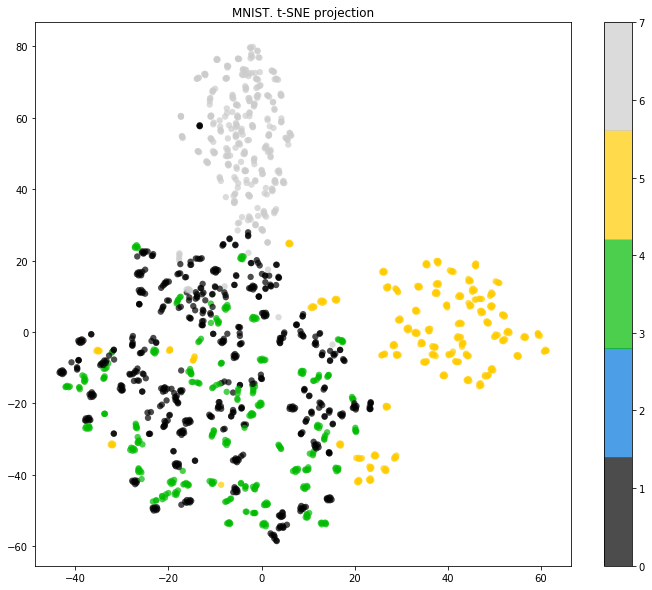

In [56]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(x_stack)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_array, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 5))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

In [27]:
import catboost

In [10]:
data = pd.DataFrame(x_stack)

In [11]:
data['y'] = y_array

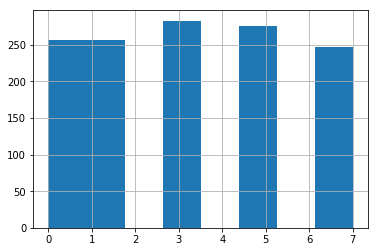

In [12]:
data['y'].hist(bins = 8)

In [13]:
data_emotions = data[(data['y']==0) | (data['y']==1)| (data['y']==3)| (data['y']==5)| (data['y']==7)]

In [14]:
data_emotions.shape

(1319, 137)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(x_stack, y_array, test_size=.05, 
                                                    random_state=42)

In [19]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(loss_function='MultiClass',)
#train the model
model.fit(X_train, y_train,verbose=False)
# make the prediction using the resulting model
preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)

In [20]:
accuracy_score(y_test,preds_class)

0.9848484848484849

In [21]:
preds_proba[0]

array([1.79820577e-02, 1.27951964e-02, 5.60822015e-04, 3.44068696e-02,
       5.60822015e-04, 9.31436277e-01, 5.60822015e-04, 1.69713297e-03])

In [22]:
model.save_model('model_yan.cbm',format="cbm", export_parameters=None)